<a href="https://colab.research.google.com/github/probabll/openfst-tutorial/blob/master/Discrete_distributions_with_OpenFST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

aIn this notebook I illustrate how we can use standard FST operations to represent distributions over structured discrete spaces.

I will start with *no* structure and represent a distribution over bit vectors, then I will introduce structure by constraining the set, in particular, I will constrain the set so that it *does not* contain certain bit vectors. 

This allows us, for example, to sample from a complement set. 

In the example I use a uniform distribution, but we can specify the actual potentials and then we would be sampling in the normalised distribution over the complement set.

In [1]:
!pip install openfst-python

     |████████████████████████████████| 15.0MB 296kB/s 


In [2]:
import openfst_python as pyfst

In [3]:
import numpy as np

Here I make an FST to represent a distribution over $3$-dimensional binary vectors. That is the sample space is $\{0, 1\}^3$.

There are no constraints in the set, other than every path contains $3$ bits.

When we represent a discrete set using a finite-state automaton, a member of the set is obtained by traversing the automaton along any path from a start state to a final state.

Concatenating the labels along the arc gives you an assignment, that is, a bit vector.


In [9]:
def get_distribution(dim=3, random=False):
    f = pyfst.Fst('log')  # negative log-prob semiring
    s0 = f.add_state()
    origin = s0
    for i in range(dim):
        destination = f.add_state()
        for w in [0, 1]:  
            # 0 is reserved for empty string in OpenFST, and I don't want to use SymbolTable (a cpp map from int to string)
            # so I am just going to store w + 1
            if random:            
                f.add_arc(origin, pyfst.Arc(w + 1, w + 1, pyfst.Weight(f.weight_type(), -np.random.normal()), destination))
            else:
                f.add_arc(origin, pyfst.Arc(w + 1, w + 1, pyfst.Weight.One(f.weight_type()), destination))
        origin = destination

    f.set_start(s0)
    f.set_final(destination, pyfst.Weight.One(f.weight_type()))
    return f

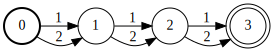

In [11]:
dist = get_distribution()
dist

Here I turn a given bit-vector into an FST

In [12]:
def make_path(bitvector):
    f = pyfst.Fst('log')
    s0 = f.add_state()
    origin = s0
    for w in bitvector:
        assert w in {0, 1}
        destination = f.add_state()
        f.add_arc(origin, pyfst.Arc(w + 1, w + 1, pyfst.Weight.One(f.weight_type()), destination))
        origin = destination
    f.set_start(s0)
    f.set_final(destination, pyfst.Weight.One(f.weight_type()))
    return f.arcsort('ilabel')  # useful for some operations, like difference

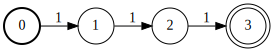

In [13]:
assignment = make_path([0, 0, 0])
assignment

We can compute intersections, here is a trivial one: $\{0, 1\}^3 \cap \{(0, 0, 0)\} = \{(0, 0, 0)\}$.

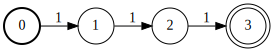

In [15]:
pyfst.intersect(dist, assignment, connect=True)

Better yet, we can intersect the complement, that is, compute the difference.

Let $\Omega = \{0, 1\}^3$ be the sample space.

Then, $\Omega \setminus \{(0, 0, 0)\}$ is the space of all bit vectors except the vector $\mathbf 0_3$.

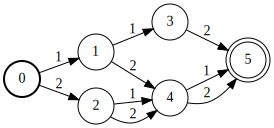

In [17]:
diff = pyfst.difference(dist, assignment, connect=True)
diff

This particular set is of great importance. Imagine a situation where each bit is associated with a component in a mixture model. Imagine we can switch components on and off, obtaining a sparse mixture. Last, assume we *cannot* switch all components off, as that would return a degenerate distribution, then this set efficiently represents all possible combinations of components except the degenerate case. Here we constructed the set using FST difference, we could also create a customised algorithm to construct this set directly. This requires a bit of custom code, but might actually lead to a more compact FST. OpenFST does have operations to compress automata, but I do not recommend using it (we would be wasting computation, since the procedure we need is far simpler). 

It is harder to represent a constrained set. Let this sink. It is true. Here is the intuition, think of a constraint as a factor that is inifinitely negative (log potential semantics). Constraining a set not to contain a bit vector introduces a factor that is non-local, since a bit vector is a *complete* assignment.

We can use shortest-distance algorithm to compute sum of probabilities. OpenFST calls it shortest-distance because algorithmically that is what it boils down to. But because OpenFST supports different semirings, semantically, this corresponds to inside weights (or backward weights if you prefer).

In [19]:
inside = pyfst.shortestdistance(diff, reverse=True)  # reverse=True is important to get the correct quantities
for i, w in enumerate(inside):
    print('paths leaving state', i, 'accumulate this much weight (in -log prob semiring)', float(w))

paths leaving state 0 accumulate this much weight (in -log prob semiring) -1.94591022
paths leaving state 1 accumulate this much weight (in -log prob semiring) -1.09861231
paths leaving state 2 accumulate this much weight (in -log prob semiring) -1.38629436
paths leaving state 3 accumulate this much weight (in -log prob semiring) 0.0
paths leaving state 4 accumulate this much weight (in -log prob semiring) -0.693147182
paths leaving state 5 accumulate this much weight (in -log prob semiring) 0.0


We can use this to compute best path, k-best paths, and also to obtain samples. Here is sampling:

In [20]:
def sample(fst, inside_table=None):
    if inside_table is None:
        inside_table = pyfst.shortestdistance(fst, reverse=True)
    # We start from the initial node
    sid = fst.start()
    path = []
    weights = []
    # and we require a specific semiring (otherwise shortestdistance won't correspond to (-log) inside weights)
    assert fst.weight_type() == 'log'  
    
    while fst.final(sid) == pyfst.Weight.Zero(dist.weight_type()):  # while not final 
        assert inside_table[sid] != pyfst.Weight.Zero(dist.weight_type())
        # in probability space this is inside[origin] * u where u ~ Uniform(0,1)
        th = float(inside_table[sid]) - np.log(np.random.uniform())
        # in probability space this corresponds to sum_{arc} arc.weight * inside[arc.destination] where arc departs from origin
        acc = pyfst.Weight.Zero(dist.weight_type())
        for arc in fst.arcs(sid):            
            acc = pyfst.plus(acc, pyfst.times(arc.weight, inside_table[arc.nextstate]))
            # in probability space this corresponds to acc/inside[origin] > u
            if float(acc) < th: break
        path.append(arc.ilabel - 1)  # to show the label as a bit we subtract 1
        weights.append(float(arc.weight))
        sid = arc.nextstate        
    return path, weights


Let's sample from the uniform distribution over all bit vectors.

In [21]:
inside = pyfst.shortestdistance(dist, reverse=True)
# Let's get 1000 samples    
samples = np.zeros([1000, 3], dtype=int)
for i in range(1000):
    path, weight = sample(dist, inside)
    samples[i] = np.array(path, dtype=int)
samples.mean(0)

array([0.491, 0.509, 0.503])

Let's check what happens when we remove `[0, 0, 0]` from the support.

In [22]:
inside_diff = pyfst.shortestdistance(diff, reverse=True)
samples_diff = np.zeros([1000, 3], dtype=int)
for i in range(1000):
    path, weight = sample(diff, inside_diff)
    samples_diff[i] = np.array(path, dtype=int)
samples_diff.mean(0)

array([0.553, 0.579, 0.555])

Note how the marginals go up, specifically they go over 0.5 indicating that each bit is independently skewed towards 1 (that's indeed the case, since we removed one of their 0 assignments).

We can do other things, for example, let's remove all bit vectors that start with a 0

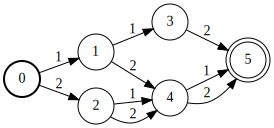

In [23]:
f = pyfst.difference(dist, make_path([0, 0, 0]), connect=True)
f

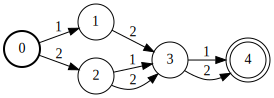

In [24]:
f = pyfst.difference(f, make_path([0, 0, 1]), connect=True)
f

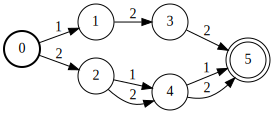

In [25]:
f = pyfst.difference(f, make_path([0, 1, 0]), connect=True)
f

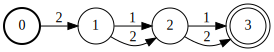

In [26]:
f = pyfst.difference(f, make_path([0, 1, 1]), connect=True)
f

And sample 

In [27]:
inside_no_zero_first = pyfst.shortestdistance(f, reverse=True)
samples_no_zero_first = np.zeros([1000, 3], dtype=int)
for i in range(1000):
    path, weight = sample(f, inside_no_zero_first)
    samples_no_zero_first[i] = np.array(path, dtype=int)
samples_no_zero_first.mean(0)

array([1.   , 0.528, 0.485])

See how the first bit is *never* 0, cool hun?!

Correlations can be coded via higher-order factors, which you can obtain via weighted intersection.

In [30]:
def make_binary_factor(factor=[0, 0], weight=1):
    """This weighted regular expression will increase the weight of a particular assignment (e.g., every sequence of adjacent zeros will get +1)."""
    assert len(factor) == 2
    f = pyfst.Fst('log')
    s0 = f.add_state()
    origin = s0
    for i, w in enumerate(factor):
        assert w in {0, 1}
        destination = f.add_state()
        if i + 1 == len(factor):
            f.add_arc(origin, pyfst.Arc(w + 1, w + 1, pyfst.Weight(f.weight_type(), weight), destination))
        else:
            f.add_arc(origin, pyfst.Arc(w + 1, w + 1, pyfst.Weight.One(f.weight_type()), destination))
        origin = destination
    f.set_start(s0)
    f.set_final(destination, pyfst.Weight.One(f.weight_type()))
    
    if factor[0] == 0:
        f.add_arc(s0, pyfst.Arc(1 + 1, 1 + 1, pyfst.Weight.One(f.weight_type()), destination))
    else:
        f.add_arc(s0, pyfst.Arc(0 + 1, 0 + 1, pyfst.Weight.One(f.weight_type()), destination))

    if factor[1] == 0:
        f.add_arc(s0 + 1, pyfst.Arc(1 + 1, 1 + 1, pyfst.Weight.One(f.weight_type()), destination))
    else:
        f.add_arc(s0 + 1, pyfst.Arc(0 + 1, 0 + 1, pyfst.Weight.One(f.weight_type()), destination))

    for w in [0, 1]:
        if w == factor[0]:
            f.add_arc(destination, pyfst.Arc(w + 1, w + 1, pyfst.Weight.One(f.weight_type()), s0 + 1))    
        else:
            f.add_arc(destination, pyfst.Arc(w + 1, w + 1, pyfst.Weight.One(f.weight_type()), destination))    
    
    return f.arcsort('ilabel')  # useful for some operations, like difference

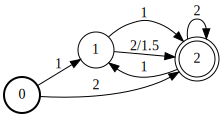

In [31]:
binary_regex = make_binary_factor([0, 1], weight=1.5)
binary_regex

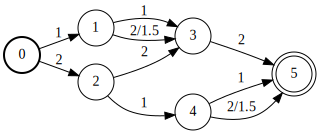

In [32]:
pyfst.intersect(dist, binary_regex)